In [39]:
import random
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque
import datetime
import os
import pickle as pkl


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

In [41]:
import os
import shutil

def clear_directory(directory_path):
    # Check if the directory exists
    if os.path.exists(directory_path):
        # Iterate over all the files and subdirectories
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            try:
                # If it's a directory, remove it
                if os.path.isdir(file_path):
                    shutil.rmtree(file_path)
                # If it's a file, delete it
                elif os.path.isfile(file_path):
                    os.remove(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
        print(f"Directory '{directory_path}' has been cleared.")
    else:
        print(f"Directory '{directory_path}' does not exist.")

# Example usage:


In [42]:

def remove_columns(df,reqcol):
    if(isinstance(df,pd.DataFrame)):
        columns=df.columns
        removcol=[]
        for i in columns:
            if(i in reqcol):
                pass
            else:
                removcol.append(i)
        df=df.drop(columns=removcol)
    elif(isinstance(df,pd.Series)):
        columns=list(df.index)
        for i in columns:
            if(i in reqcol):
                pass
            else:
                df=df.drop(i)
        
    return df
        

In [43]:



# Simple environment with random transitions (action-independent)
class RandomEnvironment:
    def __init__(self,stockdf,timestep):
        self.df=stockdf
        self.stploss=5
        self.inflat=0.0001
        self.transcost=0.01
        self.days=timestep
#         print(self.df.head())
        self.holdinfo={'Holding':0,'Hold_period':0,'Hold_Buy':0}
        self.index=list(self.df.index)
        self.curind=self.index[0]+self.days
        self.start=self.index[0]+self.days
        self.end=self.df.index[-1]
        trainreqcol=['EMA_200', 'EMA_100', 'EMA_50', 'EMA_20', 'EMA_10', 'RSI', 'EMA_12',
       'EMA_26', 'MACD', 'Signal_Line', 'ATR', 'High_pct', 'Low_pct','Close_ptc', 'Open_pct']
        self.traindf=remove_columns(self.df,trainreqcol)
        self.action_space=3
        self.df['Action']=-1
        self.feat=len(trainreqcol)
        self.performance={"Net Profit":0,"Hold days":0,"Num of Trans":0,"Net amount":100,"Profit":0,"Loss":0
                          ,"Num of Prof Trans":0,"Num of Loss Trans":0,'Avg_Daily_Prof':0}
        self.reset()
       
        
        
    def get_state(self,pos):

        state=list(self.traindf.loc[pos-self.days+1:pos].values)
        if(self.holdinfo['Holding']==1):
            net=(self.df.loc[pos]['Close']-self.holdinfo['Hold_Buy'])*100/self.holdinfo['Hold_Buy']
        else:
            net=0
        holdstate=[self.holdinfo['Holding'],self.holdinfo['Hold_period'],net]
        self.holdfeat=len(holdstate)
        state=torch.tensor(state, dtype=torch.float32)
        holdstate=torch.tensor(holdstate, dtype=torch.float32)
        return [state,holdstate]
        
        
    def reset(self):
        self.performance={"Net Profit":0,"Hold days":0,"Num of Trans":0,"Net amount":100,"Profit":0,"Loss":0
                          ,"Num of Prof Trans":0,"Num of Loss Trans":0,'Avg_Daily_Prof':0}
        self.curind=self.start
        self.holdinfo={'Holding':0,'Hold_period':0,'Hold_Buy':0}
        self.state=self.get_state(self.curind)
        return self.state


    # def findreward(self, state, prev_state, act, holdinfo):
    #     # Helper function to calculate momentum and trend
    #     def calculate_momentum(state):
    #         momentum = (state['Close'] - state['Open']) * 100 / state['Open']
    #         trend = 1 if momentum > 0 else -1
    #         return abs(momentum), trend
    #     # Calculate momentum and trend for current and next states
    #     cur_momentum, cur_trend = calculate_momentum(state)
    #     prev_momentum, prev_trend = calculate_momentum(prev_state)
    #     cur_low=min(state['Close'],state['Open'])
    #     prev_low=min(prev_state['Close'],prev_state['Open'])


    #     # Calculate price change percentage between current and next close prices
    #     price_change = (state['Close'] - prev_state['Close'])*100/prev_state['Close']


    #     # Initialize reward value
    #     MAXDAYS=20
    #     reward = 0
    #     GOALREW=10
    #     NEGPEN = -4  # Negative penalty
    #     POSREW = 5  # Positive reward multiplier
    #     INFLAT = -0.25   # Inflation factor for 'Hold' during negative price change
    #     TRANSFEE=-4
    #     goal=0
        
    #     profit_weight = 1.0
    #     risk_weight = -0.5
    #     trend_weight = 0.3
    #     transaction_cost_weight = -0.2
    #     holding_penalty_weight = -0.1
    #     if(holdinfo['Holding']==0):
    #         if(act=="Buy"):
    #             if(cur_trend==1 and price_change>0):
    #                 cur_momentum-=0.3
    #                 if(cur_momentum>prev_momentum):
    #                     reward+=POSREW
    #                 # reward+=POSREW
    #         elif(act=="Hold"):
    #             reward=0
    #         else:
    #             reward+=NEGPEN
    #     else:
    #         if(act=="Sell"):
    #             reward=-6

    #         elif(act=="Hold"):
    #             if(holdinfo['Hold_period']<MAXDAYS):
    #                 #  and cur_momentum>0.3 and price_change>0.3
    #                 # and cur_momentum>0.3 and price_change<-0.3
    #                 if(cur_trend==1 and cur_momentum>prev_momentum):
    #                     reward+=3
    #                 elif(cur_trend==-1 and cur_momentum>prev_momentum ):
    #                     reward-=2
    #             else:
    #                 reward-=1
    #         else:
    #             reward+=NEGPEN

                
                
      
    #     reward=max(-10,min(10,reward))
    #     goal=max(-10,min(10,goal))
    #     reward+=goal
    #     return reward

    def findreward(self, state, prev_state, act, holdinfo):
        # Helper function to calculate momentum and trend
        def calculate_momentum(state):
            momentum = (state['Close'] - state['Open']) * 100 / state['Open']
            trend = 1 if momentum > 0 else -1
            return abs(momentum), trend
        # Calculate momentum and trend for current and next states
        cur_momentum, cur_trend = calculate_momentum(state)
        prev_momentum, prev_trend = calculate_momentum(prev_state)
        cur_low=min(state['Close'],state['Open'])
        prev_low=min(prev_state['Close'],prev_state['Open'])


        # Calculate price change percentage between current and next close prices
        price_change = (state['Close'] - prev_state['Close'])*100/prev_state['Close']


        # Initialize reward value
        
        MAXDAYS=20
        MINDAYS=5
        POSREW=4
        NEGPEN=-6
        AVG_PROF=0.25
        MINAVGPROF_POS=AVG_PROF
        MAXAVGPROF_POS=1
        MINVAL_POS=1
        MAXVAL_POS=10
        MINAVGPROF_NEG=AVG_PROF
        MAXAVGPROF_NEG=-1
        MINVAL_NEG=-1
        MAXVAL_NEG=-10
        reward = 0
        goal=0

        if(holdinfo['Holding']==0):
            if(act=="Buy"):
                if(cur_trend==1 and price_change>0):
                    cur_momentum-=0.3
                    if(cur_momentum>prev_momentum):
                        reward+=POSREW
            elif(act=="Hold"):
                reward=0
            else:
                reward+=NEGPEN
        else:
            if(act=="Sell"):
                if(cur_trend==-1):
                    reward=-5
                else:
                    reward=-6
                if(holdinfo['Hold_period']<=MAXDAYS and holdinfo['Hold_period']>=MINDAYS):
                    prof=(state['Close']-holdinfo['Hold_Buy'])*100/holdinfo['Hold_Buy']
                    avgprof=prof/holdinfo['Hold_period']
     
                    if(avgprof>=AVG_PROF):
                        m1=(MAXVAL_POS-MINVAL_POS)/(MAXAVGPROF_POS-MINAVGPROF_POS)
                        c1=MAXVAL_POS-m1*MAXAVGPROF_POS
                        goal=int(m1*avgprof+c1)
          
                    else:
                        m2=(MAXVAL_NEG-MINVAL_NEG)/(MAXAVGPROF_NEG-MINAVGPROF_NEG)
                        c2=MAXVAL_NEG-m2*MAXAVGPROF_NEG
                        goal=int(m2*avgprof+c2)

                    goal=max(-10,min(10,goal))
                    reward+=goal
                else:
                    reward+=NEGPEN


            elif(act=="Hold"):
          
                if(holdinfo['Hold_period']<MAXDAYS):
                    if(cur_trend==1 and cur_momentum>prev_momentum):
                        reward+=3
                        if(prev_trend==cur_trend):
                            reward+=2
                    elif(cur_trend==-1 and cur_momentum>prev_momentum):
                        reward-=2
                        if(cur_trend==prev_trend):
                            reward-=1
                else:
                    reward-=2
            else:
                reward+=NEGPEN

                
        return reward


    def render(self,agent=False,plot=True,rule=False):
        done=False
        totrewardlst=[]
        state=self.reset()
        while(done==False):
            if(isinstance(agent,DQNAgent)):
                rewardlst = agent.test_agent(state)
            else:
                rewardlst=[]
                for i in ['Buy','Sell','Hold']:
                    reward=self.findreward(self.df.loc[self.curind],self.df.loc[self.curind-1],i,self.holdinfo)
                    rewardlst.append(reward)
            totrewardlst.append(rewardlst)
            
            
            action=np.argmax(rewardlst)
            # print(rewardlst)
            self.df.loc[self.curind,'Reward_Buy']=rewardlst[0]
            self.df.loc[self.curind,'Reward_Sell']=rewardlst[1]
            self.df.loc[self.curind,'Reward_Hold']=rewardlst[2]
            def calculate_momentum(state):
                # print(state['Date'])
                momentum = (state['Close'] - state['Open']) * 100 / state['Open']
                trend = 1 if state['Close']>state['Open'] else -1
                # print(state['Close'],'-',state['Open'],'=',trend)

                return abs(momentum), trend
            # print("curind-",self.curind)
            cur_mom,curtrend=calculate_momentum(self.df.loc[self.curind])
            if(self.holdinfo['Holding']==0):
                if(rule):
                    if(action==0):
                        if(curtrend==-1):
                            action=2

                if(action==1):
                    rewardlst[1]=-1000
                    action=np.argmax(rewardlst)
            else:
                if(rule):
                    if(action==1):
                        if(curtrend==1):
                            action=2
                if(rule):
                    net=(self.df.loc[self.curind]['Close']-self.holdinfo['Hold_Buy'])*100/self.holdinfo['Hold_Buy']
                    if(net<-1*self.stploss):
                        action=1
                if(action==0):
                    rewardlst[0]=-1000
                    action=np.argmax(rewardlst)
            # print("curtrend-",curtrend,"-action-",action)
            self.df.loc[self.curind,'Action']=action
            self.df.loc[self.curind,'Trend']=curtrend
            next_state,reward,done=self.step(action)
            state=next_state
        print("profit-",self.performance['Net Profit'],'-',self.performance['Net amount'],"-",self.performance['Num of Trans'])
        if(self.performance['Hold days']!=0):
            self.performance['Avg_Daily_Prof']=self.performance['Net Profit']/self.performance['Hold days']
        else:
            self.performance['Avg_Daily_Prof']=0
        print(self.performance)
        if(plot):
            self.plot_data()
        return self.performance      
    def plot_data(self):
        fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8, 42))
        df = self.df.loc[self.start:self.end-1]
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
        
        

        # Set the 'Date' column as the index
        df.set_index('Date', inplace=True)

        ax[0].set_title("Stock data")
        scatter_points = df['High'] + 0.5

        # Generate the colors based on 'Action' column
        colorlst = []
        actlst = list(df['Action'])
        for act in actlst:
            if act == 0:
                colorlst.append('green')
            elif act == 1:
                colorlst.append('red')
            else:
                colorlst.append("white")
                # colorlst.append('blue')

        # Create scatter plot and candlestick plot on ax[0]
        scatter_plot = mpf.make_addplot(scatter_points, scatter=True, markersize=20, marker='o', color=colorlst, ax=ax[0])
        mpf.plot(df, ax=ax[0], type='candle', volume=False, addplot=scatter_plot, style='yahoo', 
                tight_layout=True, scale_width_adjustment=dict(candle=0.5))
        mpf.plot(df, ax=ax[1], type='candle',tight_layout=True, scale_width_adjustment=dict(candle=0.5))

        
        # Plotting bar charts for Buy, Sell, and Hold rewards
        ind = df.index  # x-values (date index)

        buylst = list(df['Reward_Buy'])
        selllst = list(df['Reward_Sell'])
        holdlst = list(df['Reward_Hold'])
        ax[2].plot(ind,df['Momentum'],color='green')
       
        ax[2].set_title("Momentum")
        ax[2].legend()
        ax[3].plot(ind,df['Price change'],color='blue')
        ax[3].set_title("price change")

        # Bar chart for Buy rewards
        ax[6].bar(ind, buylst, color='green')
        ax[6].set_title("Buy")

        # Bar chart for Sell rewards
        ax[4].bar(ind, selllst, color='red')
        ax[4].set_title("Sell")

        # Bar chart for Hold rewards
        ax[5].bar(ind, holdlst, color='blue')
        ax[5].set_title("Hold")  # Removed `.this`

        # Show the plot
        plt.show()
    def plot_reward_function(self):

        done=False
        totrewardlst=[]
        state=self.reset()
        while(done==False):
            rewardlst=[]
            self.holdinfo['Hold']=0
            for i in ['Buy','Sell','Hold']:
                reward=self.findreward(self.df.loc[self.curind],self.df.loc[self.curind-1],i,self.holdinfo)
                rewardlst.append(reward)
            self.holdinfo['Hold']=1
            for i in ['Buy','Sell','Hold']:
                reward=self.findreward(self.df.loc[self.curind],self.df.loc[self.curind-1],i,self.holdinfo)
                rewardlst.append(reward)
            totrewardlst.append(rewardlst)
            self.df.loc[self.curind,'Reward_Buy_Hold-0']=rewardlst[0]
            self.df.loc[self.curind,'Reward_Sell_Hold-0']=rewardlst[1]
            self.df.loc[self.curind,'Reward_Hold_Hold-0']=rewardlst[2]
            self.df.loc[self.curind,'Reward_Buy_Hold-1']=rewardlst[3]
            self.df.loc[self.curind,'Reward_Sell_Hold-1']=rewardlst[4]
            self.df.loc[self.curind,'Reward_Hold_Hold-1']=rewardlst[5]
            next_state,reward,done=self.step(2)
            state=next_state
     
        fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(10,16))
        df = self.df.loc[self.start+1:self.end-1]
        # df=df.tail(90)
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
        

        # Set the 'Date' column as the index
        df.set_index('Date', inplace=True)

        ax[0][0].set_title("Stock data")
    
        ax[0][1].set_title("Stock data")
     
        mpf.plot(df, ax=ax[0][0], type='candle',tight_layout=True, scale_width_adjustment=dict(candle=0.5))
        mpf.plot(df, ax=ax[0][1], type='candle',tight_layout=True, scale_width_adjustment=dict(candle=0.5))
        
        # Plotting bar charts for Buy, Sell, and Hold rewards
        ind = df.index  # x-values (date index)

        buylst = list(df['Reward_Buy_Hold-0'])
        selllst = list(df['Reward_Sell_Hold-0'])
        holdlst = list(df['Reward_Hold_Hold-0'])
        ax[1][0].bar(ind, buylst, color='green')
        ax[1][0].set_title("Buy")

        # Bar chart for Sell rewards
        ax[2][0].bar(ind, selllst, color='red')
        ax[2][0].set_title("Sell")

        # Bar chart for Hold rewards
        ax[3][0].bar(ind, holdlst, color='blue')
        ax[3][0].set_title("Hold")  # Removed `.this`
        buylst = list(df['Reward_Buy_Hold-1'])
        selllst = list(df['Reward_Sell_Hold-1'])
        holdlst = list(df['Reward_Hold_Hold-1'])
        ax[1][1].bar(ind, buylst, color='green')
        ax[1][1].set_title("Buy")

        # Bar chart for Sell rewards
        ax[2][1].bar(ind, selllst, color='red')
        ax[2][1].set_title("Sell")

        # Bar chart for Hold rewards
        ax[3][1].bar(ind, holdlst, color='blue')
        ax[3][1].set_title("Hold")  # Removed `.this`

        # Show the plot
        plt.show()

    def step(self, action):
#         print(self.curind)
        done = False  # Define when the episode should end
        if(action==0):
            action="Buy"
        elif(action==1):
            action="Sell"
        else:
            action="Hold"
        if(self.curind==self.end-1):
            done=True

        reward=self.findreward(self.df.loc[self.curind],self.df.loc[self.curind-1],action,self.holdinfo)
        if(self.holdinfo['Holding']==0):
            if(action=='Buy'):
                self.holdinfo['Holding']=1
                self.holdinfo['Hold_Buy']=self.df.loc[self.curind]['Close']
                self.holdinfo['Hold_period']=1
            elif(action=='Sell'):
                return self.state,reward,done
            else:
                # self.holdinfo['Hold_period']+=1
                self.performance['Net amount']-=self.performance['Net amount']*self.inflat
        else:
            if(action=='Sell'):
                self.performance['Num of Trans']+=1
                profper=(self.df.loc[self.curind]['Close']-self.holdinfo['Hold_Buy'])*100/self.holdinfo['Hold_Buy']
                # print("bef init amount-",self.initamt)
                profper-=self.transcost
                self.performance['Net Profit']+=profper
                if(profper>0):
                    self.performance['Profit']+=profper
                    self.performance['Num of Prof Trans']+=1
                else:
                    self.performance['Loss']+=profper
                    self.performance['Num of Loss Trans']+=1

                self.performance['Net amount']+=((profper)*self.performance['Net amount'])/100
                # print("after init amt-",self.initamt," profper-",profper)
                self.performance['Hold days']+=self.holdinfo['Hold_period']
                
                self.holdinfo['Holding']=0
                self.holdinfo['Hold_Buy']=0
                self.holdinfo['Hold_period']=0
            elif(action=='Buy'):
                return self.state,reward,done
            else:
                self.holdinfo['Hold_period']+=1
                self.performance['Net amount']-=self.performance['Net amount']*self.inflat
                
        if(self.performance['Net amount']<=0):
            done=True
                
        
        
        self.curind+=1
        self.state =self.get_state(self.curind) 
        next_state=self.state
        return next_state, reward, done
    


In [44]:
              
# Hyperparameters
GAMMA = 0.95  # Discount factor for future rewards changed from 0.0001 to 0.00001
LEARNING_RATE = 0.01
BATCH_SIZE = 64
MEMORY_SIZE = 2000
EPSILON_START = 1.0  # For epsilon-greedy policy
EPSILON_MIN = 0.01
TRAIN_EPSILON_MIN=0.5
TRAIN_EPSILON_DECAY=0.95
EPSILON_DECAY = 0.995
TARGET_AFTER_STEP=350
LEARN_AFTER=3

In [45]:


class CustomNetwork(nn.Module):
    def __init__(self, timefeat, holdfeat,device,avail_cuda):
        super(CustomNetwork, self).__init__()
        
        # Convolutional Layers (1D Convolution + Max Pool)
        self.gpu_device=device
        self.avail_cuda=avail_cuda
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=timefeat, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, batch_first=True)  # Use 32 as input size from conv output
        
        # Dense Layers
        self.fc1 = nn.Linear(128 + holdfeat, 64)  # Concatenated hold input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)
        #defining optimizer and loss function
        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE) 
        
        self.lossfun=nn.HuberLoss()
        if(self.avail_cuda):
            self.to(self.gpu_device)

    def forward(self, timeseries_input, hold_input):
        timeseries_input=timeseries_input.permute(0,2,1)
        # Pass through the convolutional layers
        out1 = self.conv1(timeseries_input)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)

        # Use the output from the last convolutional layer
        # Permute to fit LSTM input requirements: (batch_size, seq_len, features)
        out4 = out4.permute(0, 2, 1)  # Change shape to (batch_size, features, length)
        
        # Pass through LSTM layer
        lstm_out, _ = self.lstm(out4)  # LSTM returns (output, (hn, cn))
        
        # Take the last LSTM output
        lstm_out_last = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Concatenate the LSTM output with hold input
        x = torch.cat([lstm_out_last, hold_input], dim=1)

        # Pass through Dense layers
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        x = nn.ReLU()(x)
        x = self.fc4(x)
        
        return x

    def fit(self, inputs, targets):
        """Train the model on the training data."""
        self.train()  # Set the model to training mode
       
        if(self.avail_cuda):
            inputs[0]=inputs[0].to(self.gpu_device)
            inputs[1]=inputs[1].to(self.gpu_device)
        self.optimizer.zero_grad()  # Zero the gradients
        outputs = self(inputs[0], inputs[1])  # Forward pass
        loss = self.lossfun(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        self.optimizer.step()  # Update parameters

    def predict(self, inputs):
        """Make predictions on new data."""
        self.eval()  # Set the model to evaluation mode
        # print(inputs[0].shape)
        # print(inputs[1].shape)

        if(self.avail_cuda):
            inputs[0]=inputs[0].to(self.gpu_device)
            inputs[1]=inputs[1].to(self.gpu_device)
        with torch.no_grad():  # Disable gradient tracking
            outputs = self(inputs[0], inputs[1])  # Forward pass
        return outputs



In [46]:


# Agent implementing Deep Q-Learning
class DQNAgent:
    def __init__(self,timestep,timefeat,holdfeat,action_space,multi=False):
        self.multi=multi
        self.steps=0
        self.train_epsilon=EPSILON_START
        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        avail_cuda=True if torch.cuda.is_available() else False
        device_gpu = torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self.model = CustomNetwork(timefeat,holdfeat,device_gpu,avail_cuda)
        self.target_model = CustomNetwork(timefeat,holdfeat,device_gpu,avail_cuda) # Target network for stability
        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())  # Copy weights from main model to target model
    def save_agent_state(self,info):
      
        
        f=open("agent_params.pkl",'wb')
        filename=f'model{info["Episode"]}_{round(info["Episode Loss"],1)}.pth'
        data={'epsilon':self.epsilon,'memory':self.memory,
                "filename":filename,"train_epsilon":self.train_epsilon}
        pkl.dump(data,f)
        save_dir = './target_models/'
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        modeldic=self.target_model.state_dict()
        optdic=self.model.optimizer.state_dict()
        torch.save({"model":modeldic,"optimizer":optdic},f'./target_models/{filename}')
        if(os.path.exists("./info/info.csv")):
            infodf=pd.read_csv("./info/info.csv",index_col=None)
            new_row = pd.DataFrame([info])
            infodf = pd.concat([infodf, new_row], ignore_index=True)
        else:
            info = {key: [value] for key, value in info.items()}
            infodf=pd.DataFrame(info)
        infodf.to_csv("./info/info.csv",index=False)
        return True

       
    def load_weights(self,savestate,default=True):
        print(savestate)
        if(default):
            path='./target_models/'+savestate
        else:
            path=savestate
        weightdic=torch.load(path)
        if('model' in weightdic and 'optimizer' in weightdic):
            self.target_model.load_state_dict(weightdic['model'])
            self.model.load_state_dict(weightdic['model'])
            self.model.optimizer.load_state_dict(weightdic['optimizer'])
            print("weights loaded")
        else:
            print("error")
    def load_agent_state(self):
        if(os.path.exists("agent_params.pkl") and os.path.exists("info.csv")):
            df=pd.read_csv("./info/info.csv",index_col=None)

            f=open("agent_params.pkl",'rb')
            data=pkl.load(f)
            self.epsilon=data['epsilon']
            self.train_epsilon=data['train_epsilon']
            self.memory=data['memory']
            self.load_weights(data['filename'])
            return list(df['Episode'])[-1]
        return 0
            

    



    
    def remember(self, state, action, reward, next_state, done,memque):
        if(self.multi):
            memque.append((state, action, reward, next_state, done))
        else:
            self.memory.append((state, action, reward, next_state, done))
    def test_agent(self,state):
        timeser_data=torch.unsqueeze(state[0], dim=0)
        hold_data=torch.unsqueeze(state[1], dim=0)
        q_values = self.target_model.predict([timeser_data,hold_data])
        q_values=q_values.cpu().numpy()
        return q_values[0]

    def act(self, state,epsilon=0):
        if(self.multi):
            if np.random.rand() <= epsilon:
                action=random.randrange(self.action_space)  # Random action (exploration)
            else:
                timeser_data=torch.unsqueeze(state[0], dim=0)
                hold_data=torch.unsqueeze(state[1], dim=0)
                q_values = self.model.predict([timeser_data,hold_data])
                action = torch.argmax(q_values).item()
        else:
            if np.random.rand() <= self.epsilon:
                action=random.randrange(self.action_space)  # Random action (exploration)
            else:
            
                timeser_data=torch.unsqueeze(state[0], dim=0)
                hold_data=torch.unsqueeze(state[1], dim=0)
                q_values = self.model.predict([timeser_data,hold_data])
                action = torch.argmax(q_values).item()
            
        
        return  action # Action with highest Q-value (exploitation)
    
    def replay(self,memlst=[]):
        if self.steps%LEARN_AFTER==0:
            if(self.multi):
                minibatch=[]
                if(len(memlst))>0:
                    for mem in memlst:
                        if len(mem) < BATCH_SIZE:
                            continue  # Wait until we have enough samples
                        minibatch.extend(random.sample(mem, BATCH_SIZE))
                        # Vectorize states and next states
                    if(len(minibatch)==0):
                        return
                    timestate =torch.from_numpy( np.array([state[0] for state, _, _, _, _ in minibatch]))
                    holdstate =torch.from_numpy( np.array([state[1] for state, _, _, _, _ in minibatch]))
                    next_timestate = torch.from_numpy(np.array([next_state[0] for _, _, _, next_state, _ in minibatch]))
                    next_holdstate = torch.from_numpy(np.array([next_state[1] for _, _, _, next_state, _ in minibatch]))

                    # Get Q values for current states and next states in a single batch
                    target = self.model.predict([timestate, holdstate])
                    target_next = self.target_model.predict([next_timestate, next_holdstate])

                    # Update Q values
                    for i, (_, action, reward, _, done) in enumerate(minibatch):
                        if done:
                            target[i][action] = reward
                        else:
                            target[i][action] = reward + GAMMA * torch.max(target_next[i])

                    self.model.fit([timestate,holdstate],target)
            else:

                if len(self.memory) < BATCH_SIZE:
                    return  # Wait until we have enough samples
                if self.steps%LEARN_AFTER==0:
                    minibatch = random.sample(self.memory, BATCH_SIZE)
                    # Vectorize states and next states
                    timestate =torch.from_numpy( np.array([state[0] for state, _, _, _, _ in minibatch]))
                    holdstate =torch.from_numpy( np.array([state[1] for state, _, _, _, _ in minibatch]))
                    next_timestate = torch.from_numpy(np.array([next_state[0] for _, _, _, next_state, _ in minibatch]))
                    next_holdstate = torch.from_numpy(np.array([next_state[1] for _, _, _, next_state, _ in minibatch]))

                    # Get Q values for current states and next states in a single batch
                    target = self.model.predict([timestate, holdstate])
                    target_next = self.target_model.predict([next_timestate, next_holdstate])

                    # Update Q values
                    for i, (_, action, reward, _, done) in enumerate(minibatch):
                        if done:
                            target[i][action] = reward
                        else:
                            target[i][action] = reward + GAMMA * torch.max(target_next[i])

                    self.model.fit([timestate,holdstate],target)
    def get_target_loss(self,memlst=[]):
        agent=self
        if(self.multi):
            minibatch=[]
            if(len(memlst))>0:
                for mem in memlst:
                    if len(mem) < BATCH_SIZE:
                        continue  # Wait until we have enough samples
                    minibatch.extend(random.sample(mem, BATCH_SIZE))
                    # Vectorize states and next states
                if(len(minibatch)==0):
                    return 0
        else:

            if len(agent.memory) < BATCH_SIZE:
                return 0  # Wait until we have enough samples
            minibatch = random.sample(agent.memory, BATCH_SIZE)
        y_pred=[]
        y_true=[]
        for state, action, reward, next_state, done in minibatch:
            timeser_data=torch.unsqueeze(state[0], dim=0)
            hold_data=torch.unsqueeze(state[1], dim=0)
            target = agent.target_model.predict([timeser_data,hold_data])
            y_pred.append(target[0][action])
            nex_timeser_data=torch.unsqueeze(next_state[0], dim=0)
            nex_hold_data=torch.unsqueeze(next_state[1], dim=0)
        
            t=agent.target_model.predict([nex_timeser_data,nex_hold_data])
            y_true.append(reward+GAMMA*torch.max(t[0]))
        y_true_tensor = torch.tensor(y_true, dtype=torch.float32)
        y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
        lossfun=nn.MSELoss()
        mse=lossfun(y_true_tensor,y_pred_tensor)
        # totloss=0
        # for i in range(BATCH_SIZE):
        #     totloss = huber_loss(y_true[i],y_pred[i])
        # totloss/=BATCH_SIZE
        return mse.item()



        
            
        



In [47]:
class MultiTestingEnvironment:
    def __init__(self,stocklst,timestep):
        self.trainenvlst=[]
        self.testenvlst=[]
        self.memlst=[]
        self.env_num=len(stocklst)
        for  stock_name in stocklst:
            self.df=pd.read_csv(f"data/{stock_name}.csv",index_col=None)
            self.df=self.df.tail(840)
            self.df=self.df.reset_index(drop=True)
            reqcol=['Open','High','Low','Close','Adj Close','Volume','Date']
            self.df=remove_columns(self.df,reqcol)
            self.convert_data()
            self.df=self.df.reset_index(drop=True)
            n=int(len(self.df)/2)
            print(n)
            traindf=self.df.iloc[:n]
            testdf=self.df.iloc[n:]
            trainenv=RandomEnvironment(traindf,timestep)
            testenv=RandomEnvironment(testdf,timestep)
            memory = deque(maxlen=MEMORY_SIZE)
            self.trainenvlst.append(trainenv)
            self.testenvlst.append(testenv)
            self.memlst.append(memory)
        self.epsilonlst=[1]*self.env_num
            
        self.agent=DQNAgent(self.trainenvlst[0].days,self.trainenvlst[0].feat,self.trainenvlst[0].holdfeat,3,True)
        self.randomstate=self.load_randomstate()

    def test(self,modelname):
        self.agent.load_weights(modelname)
        rules=[]
        norules=[]
        for testenv in self.testenvlst:
            res1=testenv.render(self.agent,False)
            norules.append(res1)
            res2=testenv.render(self.agent,False,True)
            rules.append(res2)
        print("With rules")
        if(len(rules)>0):
            for k in rules[0].keys():
                tot=0
                for r in rules:
                    tot+=r[k]
                avg=tot/len(rules)
                print(f"{k}-{tot}-{avg}")
        print("Without rules")
        if(len(norules)>0):
            for k in norules[0].keys():
                tot=0
                for r in norules:
                    tot+=r[k]
                avg=tot/len(norules)
                print(f"{k}-{tot}-{avg}")



        
    def train(self):
        agent=self.agent
        EPISODES =500*self.env_num
        e=0

        for e in range(e+1,EPISODES+1):
            print("Episide-",e," running")
            curind=random.randrange(0,self.env_num)
            env=self.trainenvlst[curind]
            mem=self.memlst[curind]
            epsilon=self.epsilonlst[curind]
            state = env.reset()
            infodic={}
            infodic['Episode']=e
            
            timerange=min(500,env.end-env.start)
        #     print(timerange)
            stime=datetime.datetime.now()
            totreward=0
            for time in range(timerange):  # Max time steps per episode
                action = agent.act(state,epsilon)
                next_state, reward, done = env.step(action)
                totreward+=reward
                
                
                # Remember the experience
                agent.remember(state, action, reward, next_state, done,mem)
                
                # Move to the next state
                state = next_state
                agent.steps+=1
                # Perform replay to update the Q-network
                agent.replay(self.memlst)
                
                if(agent.steps%TARGET_AFTER_STEP==0):
                    agent.update_target_model()

                if done:
                    # Update target network every episode
                    agent.update_target_model()
                    epiloss=agent.get_target_loss(self.memlst)
                    infodic['Episode']=e
                    infodic['Episode Loss']=epiloss
                    infodic['Reward']=totreward
                    infodic['Time steps']=time
                    infodic['Done']=done
                    infodic['Average Q value']=self.cal_average_qvalues().item()
                    if(env.performance['Hold days']!=0):
                        env.performance['Avg_Daily_Prof']=env.performance['Net Profit']/env.performance['Hold days']
                    else:
                        env.performance['Avg_Daily_Prof']=0
                    infodic=infodic|env.performance
                    agent.save_agent_state(infodic)
                    print(f"Episode {e}/{EPISODES}, Score: {infodic},time taken:{endtime-stime}")
                
                    break
            endtime=datetime.datetime.now()
            print(endtime,"-",stime)
            if(done==False):
                agent.update_target_model()  # Update target network every episode
                epiloss=agent.get_target_loss(self.memlst)
            
                infodic['Episode']=e
                infodic['Episode Loss']=epiloss
                infodic['Reward']=totreward
                infodic['Time steps']=time
                infodic['Done']=done
                infodic['Average Q value']=self.cal_average_qvalues().item()
                if(env.performance['Hold days']!=0):
                    env.performance['Avg_Daily_Prof']=env.performance['Net Profit']/env.performance['Hold days']
                else:
                    env.performance['Avg_Daily_Prof']=0
                infodic=infodic|env.performance
                agent.save_agent_state(infodic)
                print(f"Episode {e}/{EPISODES}, Score: {infodic},time taken:{endtime-stime}")
                        
            if epsilon > EPSILON_MIN:
                epsilon *= EPSILON_DECAY
                self.epsilonlst[curind]=epsilon
# except Exception as e:
#     print(e)
    def cal_average_qvalues(self):
        agent=self.agent
        randomstate=self.randomstate
        if(isinstance(agent,DQNAgent)):
            out=agent.target_model.predict(randomstate)
            maxval,ind=torch.max(out,dim=1)
            avgq=torch.mean(maxval)
            return avgq
    def load_randomstate(self):
        agent=self.agent
        for env in self.trainenvlst:
            state=env.reset()
            timerdata=[]
            holddata=[]

            for i in range(20):
                action=agent.act(state)
                next_state, reward, done = env.step(action)
                timerdata.append(state[0])
                holddata.append(state[1])
                state=next_state
            timerdata=torch.from_numpy(np.array(timerdata))
            holddata=torch.from_numpy(np.array(holddata))
            randomstate=[timerdata,holddata]
            return randomstate



        
    def convert_data(self):
        self.compute_indicators()
        self.df['High_pct']=(self.df['High']-self.df['Open'])*100/self.df['Open']
        self.df['Low_pct']=(self.df['Low']-self.df['Open'])*100/self.df['Open']
        self.df['Close_ptc']=(self.df['Close']-self.df['Open'])*100/self.df['Open']
        self.df['Open_pct']=(self.df['Open']-self.df['Open'].shift(1))*100/self.df['Open'].shift(1)
        self.df.dropna(inplace=True)
    def compute_indicators(self):
        data=self.df
        data['Change'] = data['Close'].diff()
        #SMA
        
        data['EMA_200'] = data['Close'].rolling(window=200).mean()
        data['EMA_100'] = data['Close'].rolling(window=100).mean()
        data['EMA_50'] = data['Close'].rolling(window=50).mean()
        data['EMA_20'] = data['Close'].rolling(window=20).mean()
        data['EMA_10'] = data['Close'].rolling(window=10).mean()
        data['EMA_200'] = (data['EMA_200']-data['Open'])*100/data['Open']
        data['EMA_100'] = (data['EMA_100']-data['Open'])*100/data['Open']
        data['EMA_50'] = (data['EMA_50']-data['Open'])*100/data['Open']
        data['EMA_10'] = (data['EMA_10']-data['Open'])*100/data['Open']
        
        
        # RSI
        delta = data['Change']
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))
        # MACD
        data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
        data['MACD'] = data['EMA_12'] - data['EMA_26']
        data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
        # ATR
        high_low = data['High'] - data['Low']
        high_close = (data['High'] - data['Close'].shift()).abs()
        low_close = (data['Low'] - data['Close'].shift()).abs()
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        data['ATR'] = true_range.rolling(window=14).mean()
        #changing with respect to open
        data['EMA_12'] = (data['EMA_12']-data['Open'])*100/data['Open']
        data['EMA_26'] = (data['EMA_26']-data['Open'])*100/data['Open']
        data['MACD'] = (data['MACD']-data['Open'])*100/data['Open']
        data['Signal_Line'] = (data['Signal_Line']-data['Open'])*100/data['Open']
        data['ATR'] = (data['ATR']-data['Open'])*100/data['Open']
        data['Momentum']=(data['Close']-data['Open'])*100/data['Open']
        data['Price change']=(data['Close'].shift(-1)-data['Close'])*100/data['Close']
        data.dropna(inplace=True)
        self.df=data





In [48]:
stocklst=["AXISBANK","BAJAJFINSV","BHARTIARTL","CIPLA","EICHERMOT"]
multienv=MultiTestingEnvironment(stocklst,90)

319
319
319
319
319


C:\Users\lok86\AppData\Local\Temp\ipykernel_4124\584064634.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Action']=-1
C:\Users\lok86\AppData\Local\Temp\ipykernel_4124\584064634.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Action']=-1
C:\Users\lok86\AppData\Local\Temp\ipykernel_4124\584064634.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [49]:
multienv.train()

Episide- 1  running
2024-11-04 05:03:30.022081 - 2024-11-04 05:03:28.343148
Episode 1/2500, Score: {'Episode': 1, 'Episode Loss': 5.628774642944336, 'Reward': -827, 'Time steps': 227, 'Done': False, 'Average Q value': 0.12417569011449814, 'Net Profit': -1.8983243178507765, 'Hold days': 68, 'Num of Trans': 33, 'Net amount': 97.1883140728932, 'Profit': 13.01747457983253, 'Loss': -14.915798897683306, 'Num of Prof Trans': 14, 'Num of Loss Trans': 19, 'Avg_Daily_Prof': -0.02791653408604083},time taken:0:00:01.678933
Episide- 2  running
2024-11-04 05:03:33.940902 - 2024-11-04 05:03:30.182110
Episode 2/2500, Score: {'Episode': 2, 'Episode Loss': 1.7654430866241455, 'Reward': -716, 'Time steps': 227, 'Done': False, 'Average Q value': 0.7834970355033875, 'Net Profit': 8.702795158393158, 'Hold days': 76, 'Num of Trans': 35, 'Net amount': 107.23397104770628, 'Profit': 33.15484914746318, 'Loss': -24.45205398907003, 'Num of Prof Trans': 20, 'Num of Loss Trans': 15, 'Avg_Daily_Prof': 0.1145104626104

KeyboardInterrupt: 

In [14]:
for  mem in multienv.memlst:
    print(len(mem))

2000
2000
2000
2000
2000


In [38]:
multienv.test("model500_0.6.pth")

model500_0.6.pth
weights loaded


C:\Users\lok86\AppData\Local\Temp\ipykernel_4124\194159089.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weightdic=torch.load(path)


profit- -4.875858666714476 - 92.66566992059582 - 7
{'Net Profit': -4.875858666714476, 'Hold days': 65, 'Num of Trans': 7, 'Net amount': 92.66566992059582, 'Profit': 9.073258154957184, 'Loss': -13.949116821671662, 'Num of Prof Trans': 3, 'Num of Loss Trans': 4, 'Avg_Daily_Prof': -0.07501321025714577}
profit- 1.1051117965332082 - 98.5075589781286 - 5
{'Net Profit': 1.1051117965332082, 'Hold days': 56, 'Num of Trans': 5, 'Net amount': 98.5075589781286, 'Profit': 8.628137931471858, 'Loss': -7.52302613493865, 'Num of Prof Trans': 2, 'Num of Loss Trans': 3, 'Avg_Daily_Prof': 0.01973413922380729}
profit- 4.850073818572602 - 102.28010346699162 - 3
{'Net Profit': 4.850073818572602, 'Hold days': 31, 'Num of Trans': 3, 'Net amount': 102.28010346699162, 'Profit': 8.15691926866557, 'Loss': -3.3068454500929683, 'Num of Prof Trans': 1, 'Num of Loss Trans': 2, 'Avg_Daily_Prof': 0.15645399414750327}
profit- 0 - 97.7359095756714 - 0
{'Net Profit': 0, 'Hold days': 0, 'Num of Trans': 0, 'Net amount': 97.7

In [14]:
multienv.test("model500_0.7.pth")

model500_0.7.pth
weights loaded


C:\Users\lok86\AppData\Local\Temp\ipykernel_13688\194159089.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weightdic=torch.load(path)


m2- 7.2 -c2- -2.8
profit- 16.963106222765457 - 114.5484450999422 - 4
{'Net Profit': 16.963106222765457, 'Hold days': 114, 'Num of Trans': 4, 'Net amount': 114.5484450999422, 'Profit': 22.22592693668204, 'Loss': -5.262820713916582, 'Num of Prof Trans': 3, 'Num of Loss Trans': 1, 'Avg_Daily_Prof': 0.14879917739267945}
m2- 7.2 -c2- -2.8
m2- 7.2 -c2- -2.8
profit- 6.147595025233274 - 102.92921752296749 - 4
{'Net Profit': 6.147595025233274, 'Hold days': 89, 'Num of Trans': 4, 'Net amount': 102.92921752296749, 'Profit': 17.1358349031632, 'Loss': -10.988239877929926, 'Num of Prof Trans': 2, 'Num of Loss Trans': 2, 'Avg_Daily_Prof': 0.06907410140711544}
profit- -0.3651413014924323 - 96.87668602790563 - 2
{'Net Profit': -0.3651413014924323, 'Hold days': 124, 'Num of Trans': 2, 'Net amount': 96.87668602790563, 'Profit': 7.32655939175202, 'Loss': -7.691700693244452, 'Num of Prof Trans': 1, 'Num of Loss Trans': 1, 'Avg_Daily_Prof': -0.0029446879152615507}
profit- -5.491340810876027 - 91.94341410115

In [63]:
multienv.test("model475_0.2.pth")

model475_0.2.pth
weights loaded


C:\Users\lok86\AppData\Local\Temp\ipykernel_23456\194159089.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weightdic=torch.load(path)


profit- 42.833988810079234 - 146.56642039408504 - 5
{'Net Profit': 42.833988810079234, 'Hold days': 170, 'Num of Trans': 5, 'Net amount': 146.56642039408504, 'Profit': 42.833988810079234, 'Loss': 0, 'Num of Prof Trans': 5, 'Num of Loss Trans': 0}
profit- 30.76273150523489 - 130.45456549639698 - 4
{'Net Profit': 30.76273150523489, 'Hold days': 188, 'Num of Trans': 4, 'Net amount': 130.45456549639698, 'Profit': 30.84859847577621, 'Loss': -0.08586697054132277, 'Num of Prof Trans': 3, 'Num of Loss Trans': 1}
profit- 3.443211827235265 - 101.121387239871 - 1
{'Net Profit': 3.443211827235265, 'Hold days': 14, 'Num of Trans': 1, 'Net amount': 101.121387239871, 'Profit': 3.443211827235265, 'Loss': 0, 'Num of Prof Trans': 1, 'Num of Loss Trans': 0}
profit- 2.5552014252847477 - 100.2533085893487 - 1
{'Net Profit': 2.5552014252847477, 'Hold days': 12, 'Num of Trans': 1, 'Net amount': 100.2533085893487, 'Profit': 2.5552014252847477, 'Loss': 0, 'Num of Prof Trans': 1, 'Num of Loss Trans': 0}
profit-

C:\Users\lok86\AppData\Local\Temp\ipykernel_12184\1118382799.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


profit- -1.0313641508072298 - 95.53838315735665 - 2
{'Net Profit': -1.0313641508072298, 'Hold days': 2, 'Num of Trans': 2, 'Net amount': 95.53838315735665, 'Profit': 0, 'Loss': -1.0313641508072298, 'Num of Prof Trans': 0, 'Num of Loss Trans': 2}


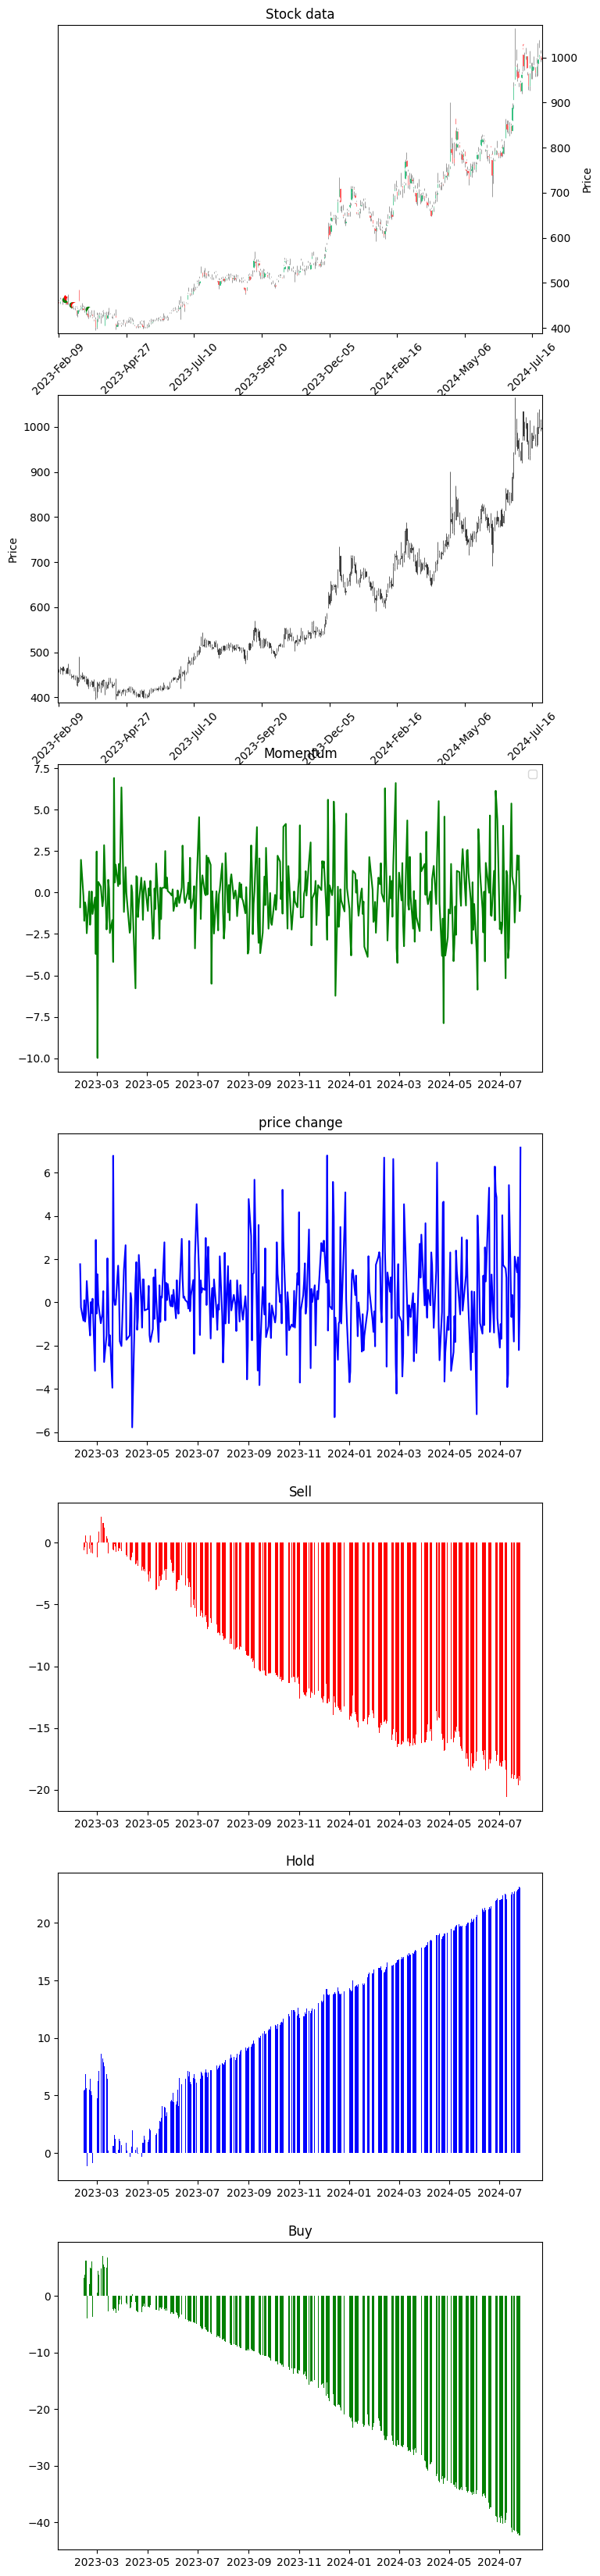

In [ ]:
stock_name2='data/360ONE.csv'
env2=RandomEnvironment(stock_name2,90)
env2_per=env2.render(agent,True)

profit- 0 - 96.48315136708113 - 0
{'Net Profit': 0, 'Hold days': 0, 'Num of Trans': 0, 'Net amount': 96.48315136708113, 'Profit': 0, 'Loss': 0, 'Num of Prof Trans': 0, 'Num of Loss Trans': 0}
profit- -3.7490991429082072 - 92.96120037850554 - 3
{'Net Profit': -3.7490991429082072, 'Hold days': 29, 'Num of Trans': 3, 'Net amount': 92.96120037850554, 'Profit': 0, 'Loss': -3.7490991429082072, 'Num of Prof Trans': 0, 'Num of Loss Trans': 3}


C:\Users\lok86\AppData\Local\Temp\ipykernel_12184\1118382799.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


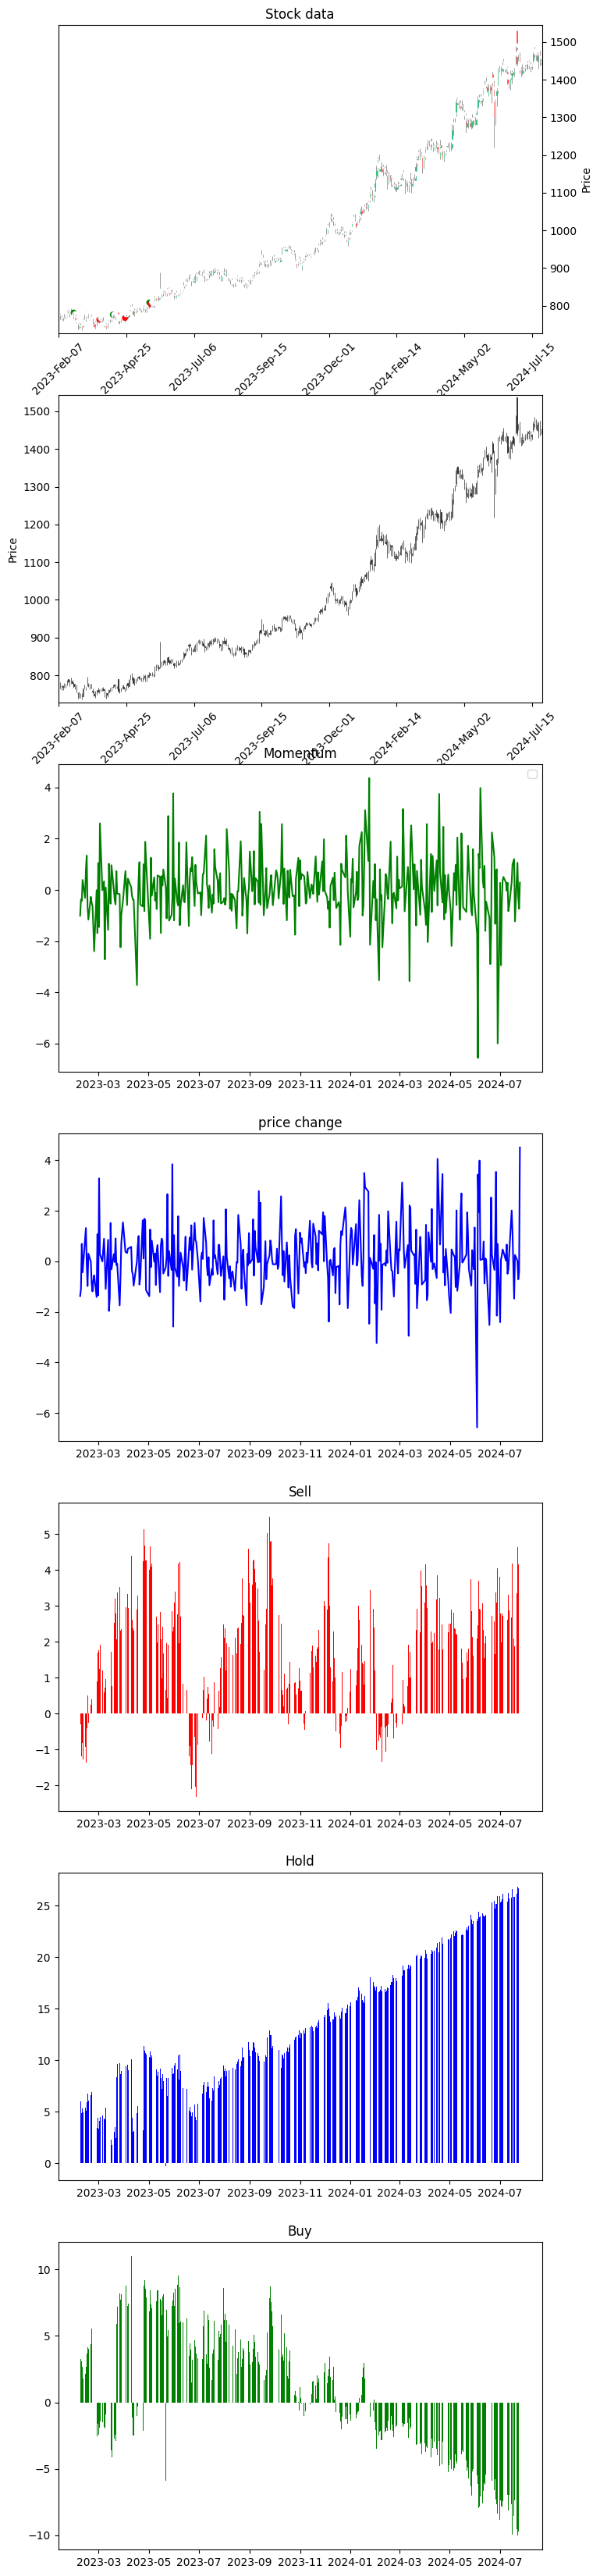

profit- 0 - 96.48315136708113 - 0
{'Net Profit': 0, 'Hold days': 0, 'Num of Trans': 0, 'Net amount': 96.48315136708113, 'Profit': 0, 'Loss': 0, 'Num of Prof Trans': 0, 'Num of Loss Trans': 0}
average Net Profit--1.25
average Hold days-9.67
average Num of Trans-1.0
average Net amount-95.31
average Profit-0.0
average Loss--1.25
average Num of Prof Trans-0.0
average Num of Loss Trans-1.0


In [81]:
perlst=[]
stock_name2='data/BAJAJFINSV.csv'
env2=RandomEnvironment(stock_name2,90)
env2_per=env2.render(agent,False)
stock_name3='data/BHARTIARTL.csv'
env3=RandomEnvironment(stock_name3,90)
env3_per=env3.render(agent,True)
stock_name4='data/ABBOTINDIA.csv'
env4=RandomEnvironment(stock_name4,90)
env4_per=env4.render(agent,False)
perlst=[env2_per,env3_per,env4_per]
for i in env2_per.keys():
    tot=0
    for per in perlst:
        tot+=per[i]

    tot/=len(perlst)
    tot=round(tot,2)
    print(f"average {i}-{tot}")
